In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [8]:
data = pd.read_csv('Documents/Proyectos/Dataset obesidad/data_obesity.csv')
data

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity,IMC
0,Female,21.000000,1.620000,64.000000,yes,no,2,3,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight,24.386526
1,Female,21.000000,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight,24.238227
2,Male,23.000000,1.800000,77.000000,yes,no,2,3,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight,23.765432
3,Male,27.000000,1.800000,87.000000,no,no,3,3,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I,26.851852
4,Male,22.000000,1.780000,89.800000,no,no,2,1,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II,28.342381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3,3,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III,44.901475
2107,Female,21.982942,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III,43.741923
2108,Female,22.524036,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III,43.543817
2109,Female,24.361936,1.739450,133.346641,yes,yes,3,3,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III,44.071535


# MODELOS DE ML

## Separamos los datos en train y test

In [9]:
X = data[data.columns[data.columns!='Obesity']]

y = data['Obesity']

In [10]:
print(X.shape)
print(y.shape)

(2111, 17)
(2111,)


Separamos en entrenamiento y test

In [11]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1583, 17)
(1583,)
(528, 17)
(528,)


## Tenemos valores atípicos?

In [12]:
data_num = data[['Age','Height','Weight','CH2O','FAF','TUE','IMC']]
data_num 
mean = data_num.mean(axis=0)
median = data_num.median(axis=0)

pd.concat([mean, median, mean-median], axis=1, keys=["Media", "Mediana", "Diferencia"])

,Media,Mediana,Diferencia
Age,24.312600,22.777890,1.534710
Height,1.701677,1.700499,0.001178
Weight,86.586058,83.000000,3.586058
CH2O,2.008011,2.000000,0.008011
FAF,1.010298,1.000000,0.010298
TUE,0.657866,0.625350,0.032516
IMC,29.700159,28.719089,0.981070


In [13]:
#Obtener 1.5 el rango intercuartilico
iqrx15 = (data_num.quantile(0.75)-data_num.quantile(0.25))*1.5
#Obtener los valores maximos
maxs = data_num.max()
#Obtener los valores minimos
mins = data_num.min()
#Definir un limite superior igual a la mediana mas 1.5 veces el rango intercuartilico
sup = median + iqrx15
#Definir un limite inferior igual a la mediana menos 1.5 veces el rango intercuartilico
inf = median - iqrx15
#Comprobar si los valores maximos estan mas alla del limite superior
out_sup = maxs > sup
#Comprobar si los valores minimos estan mas alla del limite inferior
out_inf = maxs < inf 
#Mostramos para que variables existen valores atipicos
pd.concat([out_sup, out_inf], axis=1, keys=["Outlier Sup", "Outlier Inf"])

,Outlier Sup,Outlier Inf
Age,True,False
Height,True,False
Weight,True,False
CH2O,False,False
FAF,False,False
TUE,False,False
IMC,True,False


Vemos que tenemos valores atípicos, por lo que vamos a utilizar el RobustScaler.

## Preprocesamos las variables categóricas

In [14]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

# Convertir 'Obesity' a valores numéricos
encoder1 = LabelEncoder()
y_train = encoder1.fit_transform(y_train)
y_test = encoder1.transform(y_test)

one_hot = ['FCVC','NCP','CAEC','CALC','MTRANS']
label = ['family_history', 'FAVC','Gender','SMOKE','SCC']
robust = ['Age','Height','Weight','CH2O','FAF','TUE','IMC']

preprocessor = ColumnTransformer(
                   [('label', OrdinalEncoder(), label),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot),
                   ('robust', RobustScaler(), robust)],
                remainder='passthrough')



In [15]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Realizamos las predicciones

### KNN con el vecino óptimo

In [16]:
#SOLUCION
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error


k_max =20
rang_K = np.arange(1, k_max+1)
tuned_parameters = [{'n_neighbors': rang_K}]
nfold = 5

# Definir el modelo de clasificacion kNN con validación cruzada y entrenarlo
# Configurar CV para que devuelva las puntuaciones de entrenamiento
neigh_CV = GridSearchCV(KNeighborsClassifier(), 
                        tuned_parameters, 
                        cv=nfold, 
                        return_train_score=True).fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est = neigh_CV.predict(X_test) 

# Obtener el error cuadratico medio y la precision
MSE_tst_KNN = mean_squared_error(y_est,y_test)
accuracy_KNN = neigh_CV.score(X_test,y_test)

# Se puede obtener el mejor parametro asi
K_CV = neigh_CV.best_params_['n_neighbors']

print('MSE : ' + str(MSE_tst_KNN))
print('Accuracy: ' + str(accuracy_KNN))
print('Selected value of k: ' + str(K_CV))

  File "C:\Users\prueb\anaconda3\envs\nuevo-entorno\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\prueb\anaconda3\envs\nuevo-entorno\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\prueb\anaconda3\envs\nuevo-entorno\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\prueb\anaconda3\envs\nuevo-entorno\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


MSE : 1.1931818181818181
Accuracy: 0.8806818181818182
Selected value of k: 1


Confusion matrix
[[63  4  0  0  0  1  0]
 [11 48  3  0  0 10  6]
 [ 0  1 86  4  0  1  2]
 [ 0  0  2 73  0  0  0]
 [ 0  0  0  0 79  0  0]
 [ 2  6  0  0  0 62  1]
 [ 1  0  2  1  0  5 54]]


[Text(170.72222222222223, 0.5, 'True'),
 Text(0.5, 80.7222222222222, 'Predicted')]

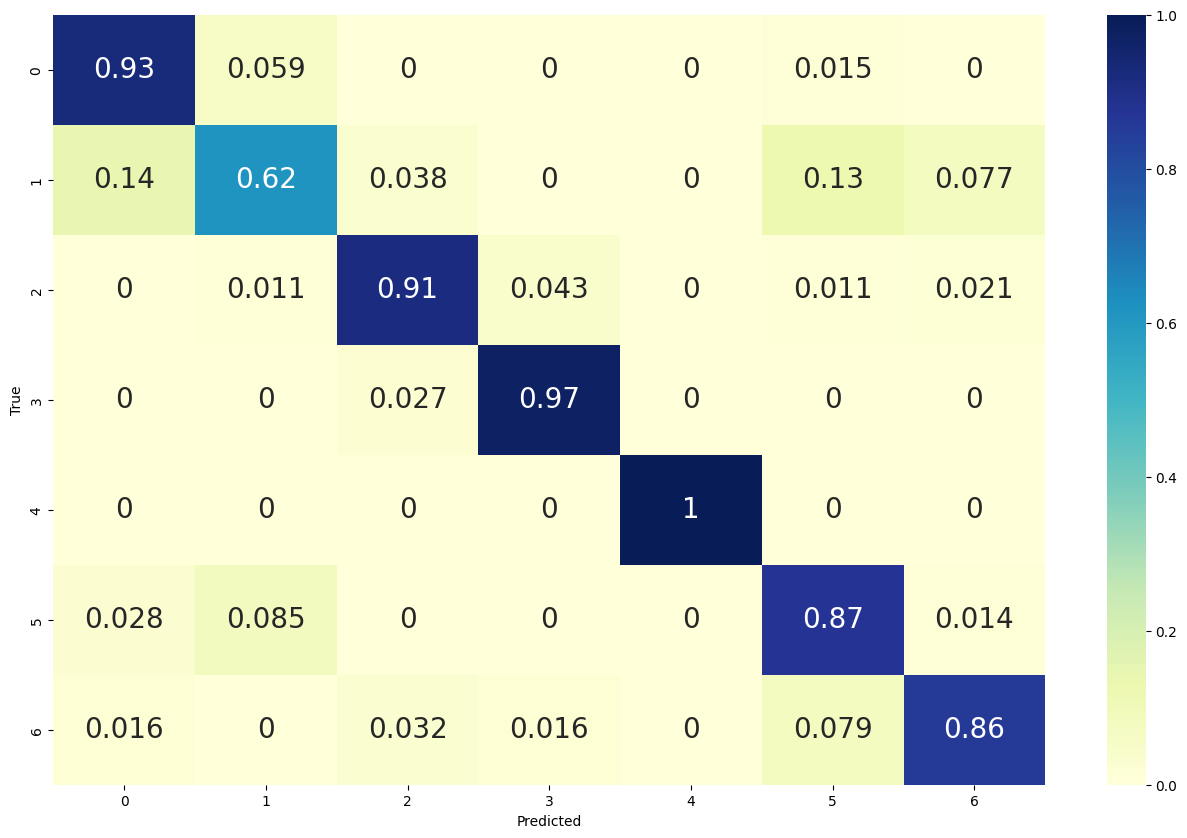

In [17]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(CM_norm)
plt.figure(figsize=(16,10))
sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### Regresión Logística

In [18]:
from sklearn.linear_model import LogisticRegression

# Definir y entrenar el modelo de regresion logistica
l_reg = LogisticRegression().fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est = l_reg.predict(X_test) 

# Obtener el error cuadratico medio y la precision
MSE_tst_LR = mean_squared_error(y_test, y_est)
accuracy_LR = l_reg.score(X_test,y_test)

# Imprimimos el error y precision del modelo
print('MSE : ' + str(MSE_tst_LR))
print('Accuracy: ' + str(accuracy_LR))

MSE : 0.9147727272727273
Accuracy: 0.8693181818181818


Confusion matrix
[[67  1  0  0  0  0  0]
 [15 53  0  0  0  6  4]
 [ 0  0 85  6  1  0  2]
 [ 0  0  0 75  0  0  0]
 [ 0  0  0  1 78  0  0]
 [ 0 10  0  0  0 48 13]
 [ 0  0  3  0  0  7 53]]


[Text(170.72222222222223, 0.5, 'True'),
 Text(0.5, 80.7222222222222, 'Predicted')]

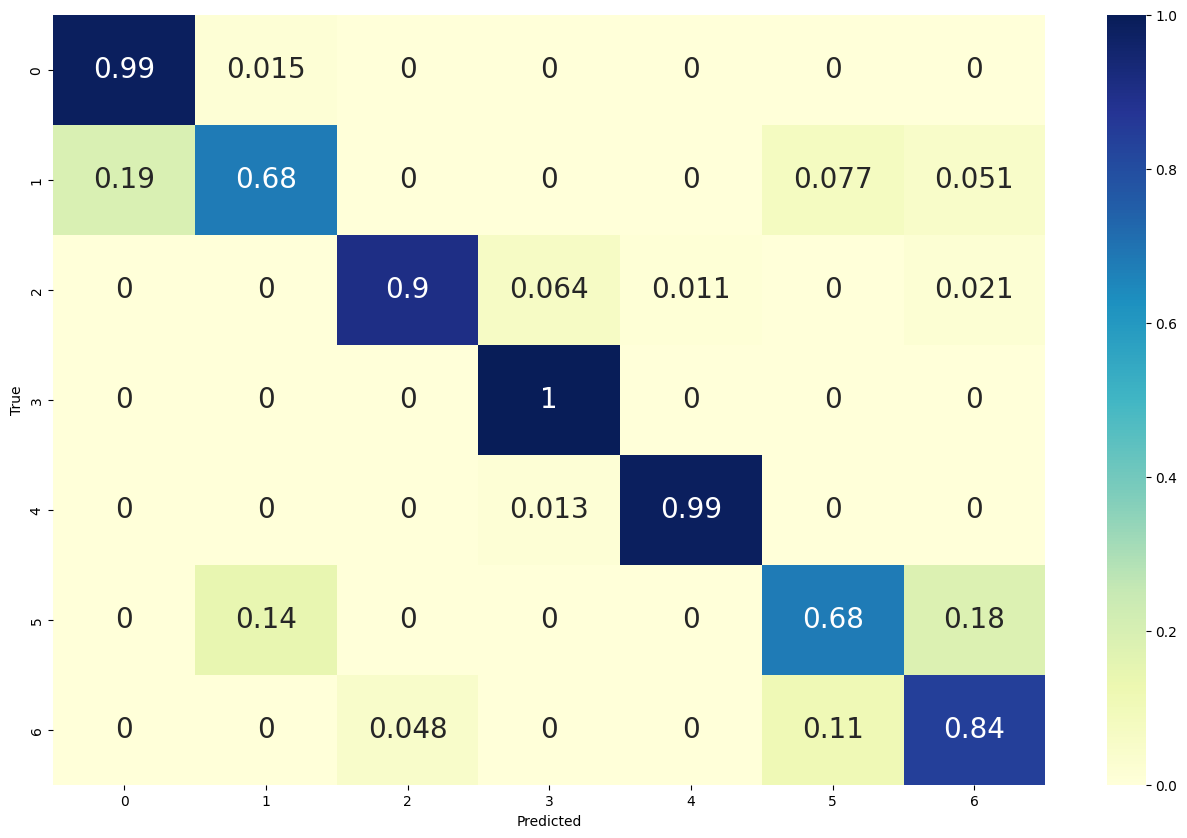

In [19]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(CM_norm)
plt.figure(figsize=(16,10))
sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### RIDGE con alpha óptimo

In [20]:
from sklearn.linear_model import RidgeClassifier

rang_alpha = np.logspace(-3, 1, 100)
tuned_parameters = [{'alpha': rang_alpha}]
nfold = 5

# Definir el modelo de regresion logística con validación cruzada y entrenarlo
# Configurar CV para que devuelva las puntuaciones de entrenamiento
ridge_CV = GridSearchCV(RidgeClassifier(), 
                        tuned_parameters, 
                        cv=nfold, 
                        return_train_score=True).fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est = ridge_CV.predict(X_test) 

# Obtener el error cuadratico medio y la precision
MSE_tst_RIDGE = mean_squared_error(y_est,y_test)
accuracy_RIDGE = ridge_CV.score(X_test,y_test)

# Se puede obtener el mejor parametro asi
alpha_CV = ridge_CV.best_params_['alpha']

print('MSE : ' + str(MSE_tst_RIDGE))
print('Accuracy: ' + str(accuracy_RIDGE))
print('Selected value of alpha: ' + str(alpha_CV))

MSE : 2.981060606060606
Accuracy: 0.6534090909090909
Selected value of alpha: 9.111627561154895


Confusion matrix
[[64  1  0  0  0  3  0]
 [35 19  3  1  0  9 11]
 [ 1  2 53 23 11  1  3]
 [ 0  0  3 70  2  0  0]
 [ 0  0  0  1 78  0  0]
 [12  7  4  4  0 34 10]
 [ 0  4 13 11  4  4 27]]


[Text(170.72222222222223, 0.5, 'True'),
 Text(0.5, 80.7222222222222, 'Predicted')]

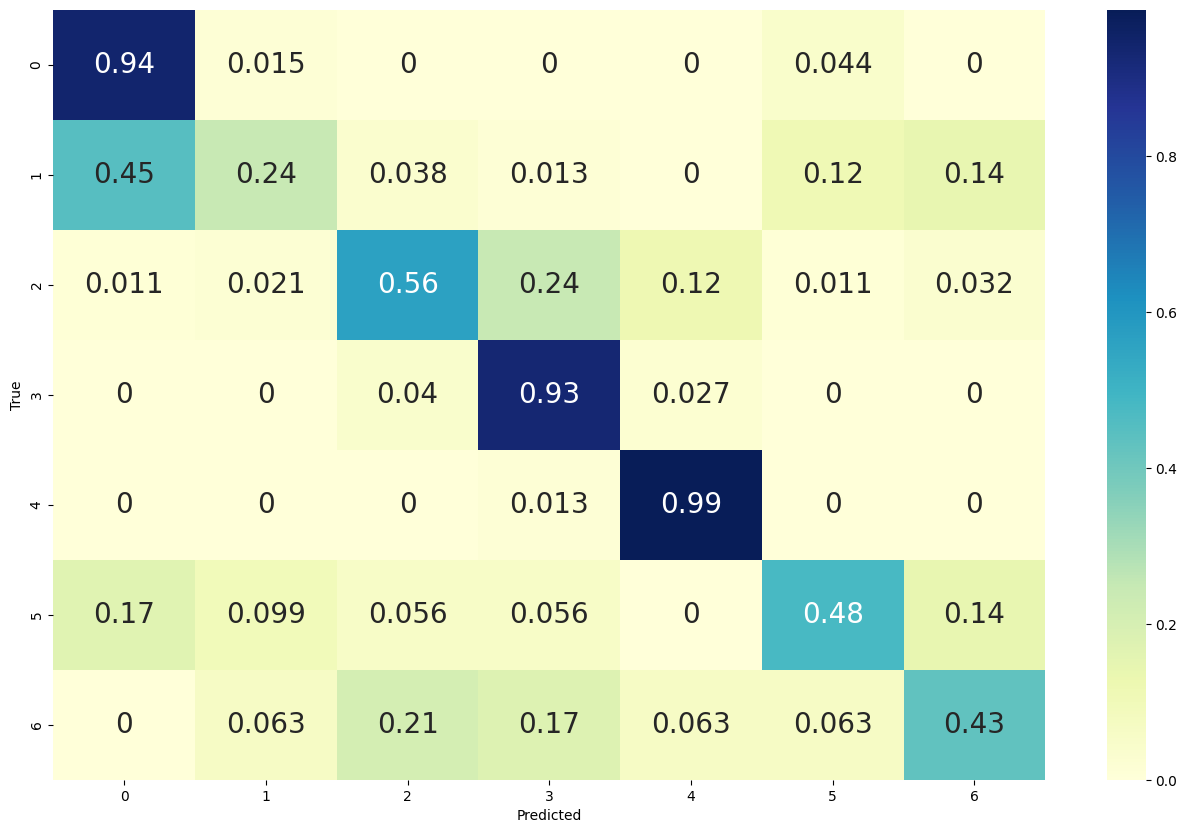

In [21]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(CM_norm)
plt.figure(figsize=(16,10))
sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### SGD con mejores hiperparámetros

In [22]:
from sklearn.linear_model import SGDClassifier

rang_alpha = np.logspace(-3, 1, 10)
perdida = ['log_loss','squared_error','hinge']
penalty = ['l2','l1',None,'elasticnet']
tuned_parameters = [{'alpha': rang_alpha,
                    'loss': perdida,
                   'penalty': penalty}]
nfold = 5

# Definir el modelo de regresion lineal con validación cruzada y entrenarlo
# Configurar CV para que devuelva las puntuaciones de entrenamiento
SGDC = GridSearchCV(SGDClassifier(),tuned_parameters, cv=nfold, return_train_score=True).fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est = SGDC.predict(X_test)

# Obtener el error cuadratico medio y el coeficiente R2
MSE_tst_SGD = mean_squared_error(y_est,y_test)
accuracy_SGD = SGDC.score(X_test,y_test)

penalty_CV = SGDC.best_params_['penalty']
alpha_CV = SGDC.best_params_['alpha']
loss_CV = SGDC.best_params_['loss']


print('MSE : ' + str(MSE_tst_SGD))
print('Accuracy: ' + str(accuracy_SGD))
print('Selected value of penalty: ' + str(penalty_CV))
print('Selected value of alpha: ' + str(alpha_CV))
print('Selected value of loss: ' + loss_CV)

MSE : 2.481060606060606
Accuracy: 0.7784090909090909
Selected value of penalty: l1
Selected value of alpha: 0.001
Selected value of loss: log_loss


Confusion matrix
[[68  0  0  0  0  0  0]
 [ 7 45  1  0  0 15 10]
 [ 0  1 69  5  0  9 10]
 [ 0  0  0 75  0  0  0]
 [ 0  0  0  1 78  0  0]
 [ 0 11  4  0  0 45 11]
 [ 0  6 11  0  0 15 31]]


[Text(170.72222222222223, 0.5, 'True'),
 Text(0.5, 80.7222222222222, 'Predicted')]

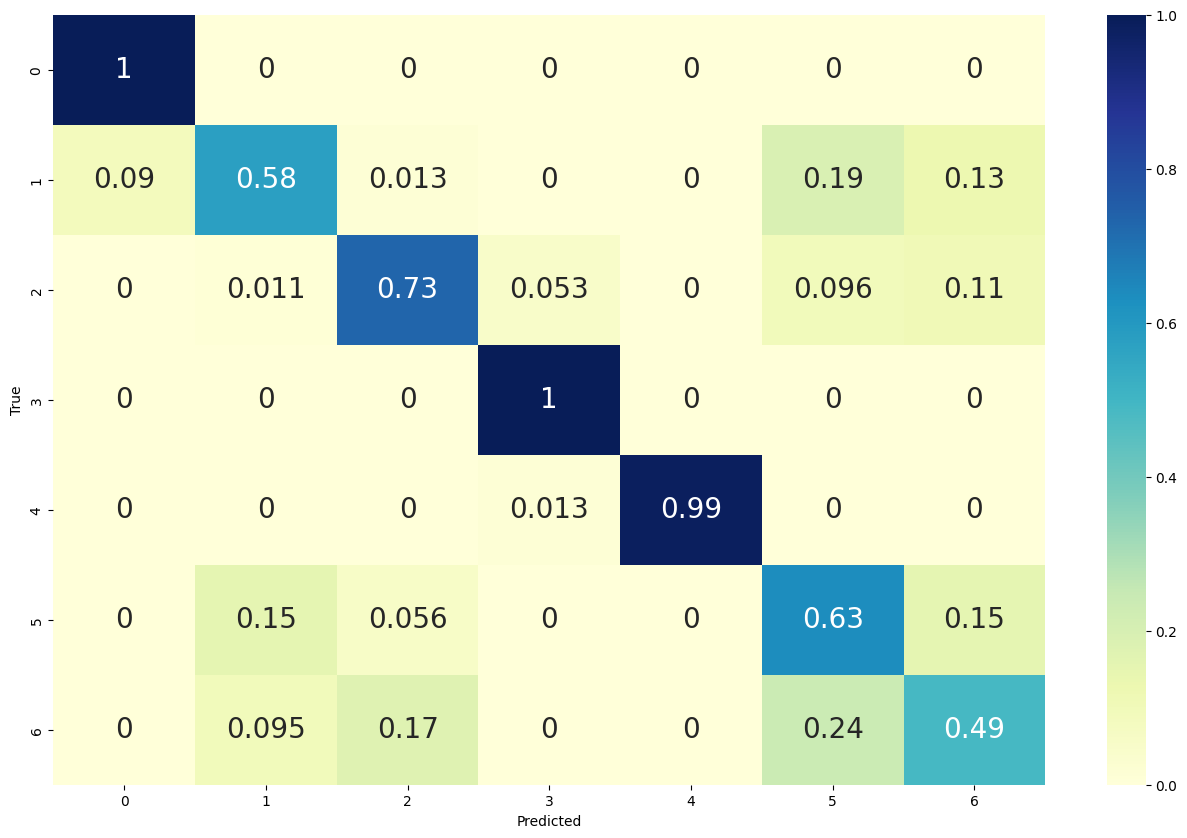

In [23]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(CM_norm)
plt.figure(figsize=(16,10))
sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### OVO Y OVR

In [24]:
from sklearn.multiclass import OneVsRestClassifier
# 1 vs. rest
clf_1vsall = OneVsRestClassifier(SGDClassifier(loss='log_loss', penalty = 'l1', alpha=0.001)).fit(X_train, y_train)

# Entrenar SGDClassifier con configuracion 1 vs. 1
from sklearn.multiclass import OneVsOneClassifier
# 1 vs. 1
clf_1vs1 = OneVsOneClassifier(SGDClassifier(loss='log_loss', penalty = 'l1', alpha=0.001)).fit(X_train, y_train)

# Obtener el numero de clasificadores
num_clf_1vsall=len(clf_1vsall.estimators_)
num_clf_1vs1=len(clf_1vs1.estimators_)
print("The number of classfiers in 1 vs. all configuration is %d" %(num_clf_1vsall))
print("The number of classfiers 1 vs. 1 configuration is %d" %(num_clf_1vs1))

# Obtener la precisión de los modelos
acc_1vsall = clf_1vsall.score(X_test,y_test)
acc_1vs1 = clf_1vs1.score(X_test,y_test)
print("The test accuracy in 1 vs. all configuration is %2.2f%%" %(100*acc_1vsall))
print("The test accuracy in 1 vs. 1 configuration is %2.2f%%" %(100*acc_1vs1))

The number of classfiers in 1 vs. all configuration is 7
The number of classfiers 1 vs. 1 configuration is 21
The test accuracy in 1 vs. all configuration is 77.65%
The test accuracy in 1 vs. 1 configuration is 96.02%


In [25]:
y_est_ovr = clf_1vsall.predict(X_test)
y_est_ovo = clf_1vs1.predict(X_test)

Confusion matrix OVR
[[67  1  0  0  0  0  0]
 [ 7 43  3  0  0 14 11]
 [ 0  1 73  8  0  4  8]
 [ 0  0  0 75  0  0  0]
 [ 0  0  0  1 78  0  0]
 [ 0 10  5  1  0 44 11]
 [ 0  6 17  0  0 10 30]]


[Text(170.72222222222223, 0.5, 'True'),
 Text(0.5, 80.7222222222222, 'Predicted')]

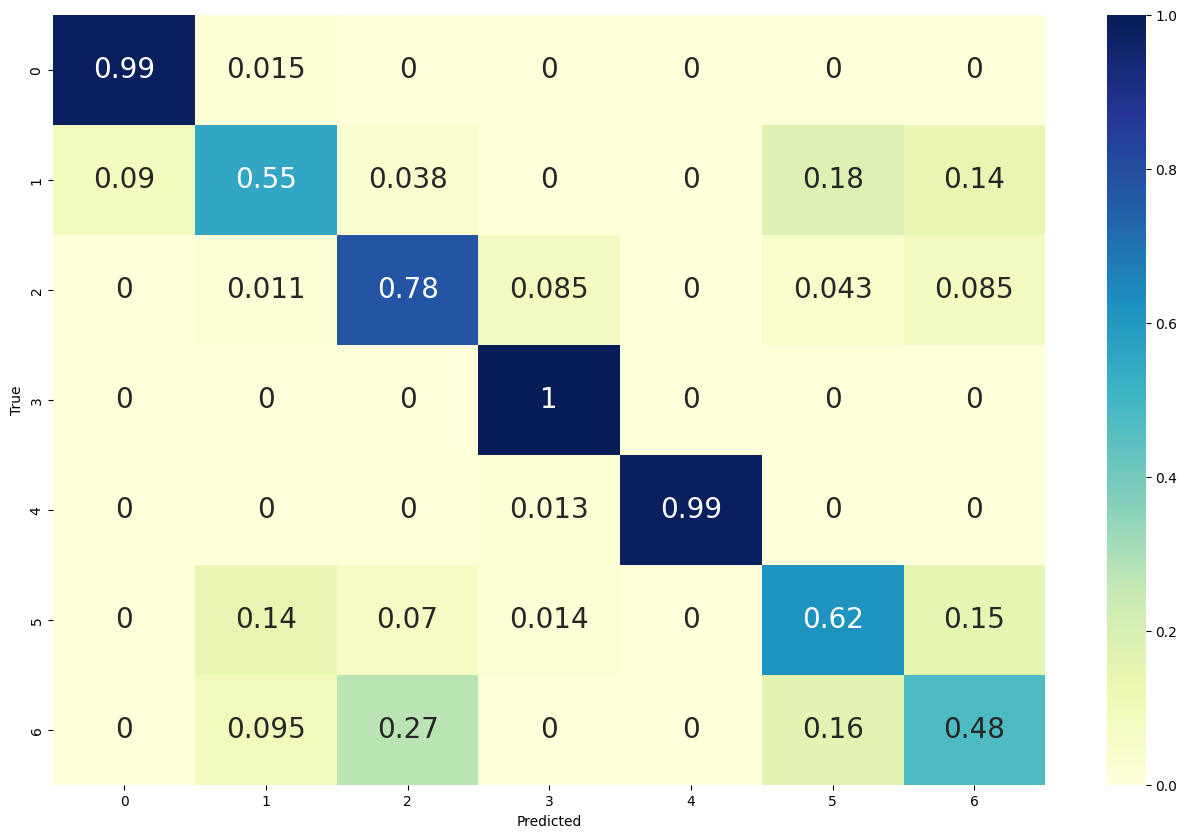

In [26]:
CM = confusion_matrix(y_test, y_est_ovr)
print('Confusion matrix OVR')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(CM_norm)
plt.figure(figsize=(16,10))
sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

Confusion matrix OVO
[[66  2  0  0  0  0  0]
 [ 5 68  0  0  0  5  0]
 [ 0  0 92  2  0  0  0]
 [ 0  0  0 75  0  0  0]
 [ 0  0  0  1 78  0  0]
 [ 0  1  0  0  0 69  1]
 [ 0  0  1  0  0  3 59]]


[Text(170.72222222222223, 0.5, 'True'),
 Text(0.5, 80.7222222222222, 'Predicted')]

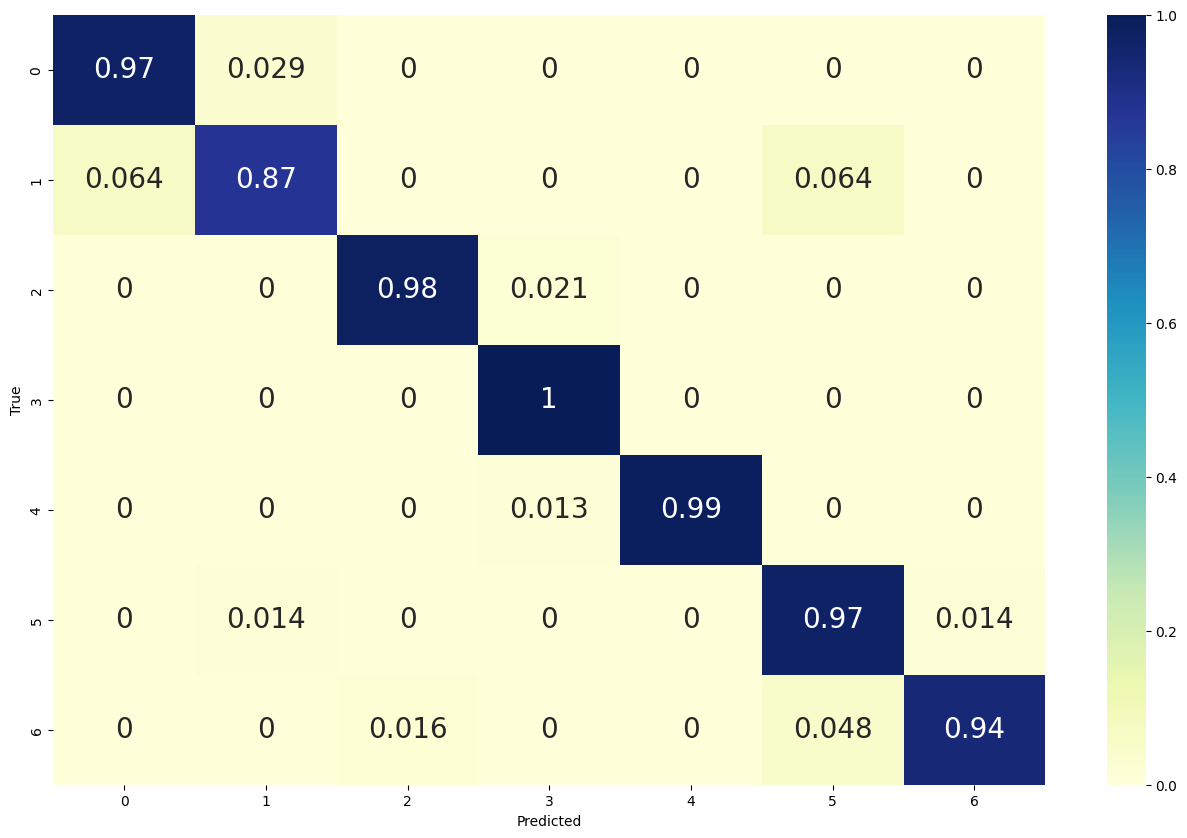

In [27]:
CM = confusion_matrix(y_test, y_est_ovo)
print('Confusion matrix OVO')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(CM_norm)
plt.figure(figsize=(16,10))
sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

Podemos observar como el mejor modelo que hemos creado es el OVO.

### BAGGING

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

base = tree.DecisionTreeClassifier(max_depth=1)
bag = BaggingClassifier(estimator=base, n_estimators=10, max_samples=0.5, max_features=0.5).fit(X_train, y_train)
acc_test = bag.score(X_test,y_test)

print('Accuracy of bagged ensemble is %2.2f '%(100*acc_test))

Accuracy of bagged ensemble is 62.69 


Observamos que haciendo bagging con 10 árboles de decisión de profundidad 1, el accuracy no es muy bueno y además el resultado no es muy fiable ya que es aleatorio.

Vamos a probar a hacer bagging con 50 iteraciones. En cada iteración vamos a crear 10 BaggingClassifier, cada uno con un número de árboles diferentes (desde 1 hasta 10 árboles), vamos a guardarnos el mejor modelo en cada iteración. De ese mejor modelo sacamos el accuracy y el número de árboles utilizados. Hacemos esto 50 veces, por lo que obtendremos 50 accuracys y 50 números de árboles utilizados, y nos quedamos con la media del accuracy y los árboles.

In [29]:
# Initialize the random generator seed to compare results
np.random.seed(0)

rang_n_trees=np.arange(1,20)
tuned_parameters = [{'n_estimators': rang_n_trees}]
nfold = 3

# Create Bagging classifier object with CV

grid = GridSearchCV(BaggingClassifier(), tuned_parameters, cv=nfold)
acc_bagging_vector = []
n_trees_vector = []

for run in np.arange(50):
    grid.fit(X_train, y_train)
    acc = grid.score(X_test, y_test)
    acc_bagging_vector.append(acc)
    n_trees_vector.append(grid.best_estimator_.n_estimators)
    
# Compute averaged accuracies and number of used trees
mean_acc_Bagging = np.mean(np.array(acc_bagging_vector))
std_acc_Bagging = np.std(np.array(acc_bagging_vector))

mean_n_trees = np.mean(np.array(n_trees_vector))
std_n_trees = np.std(np.array(n_trees_vector))

# Print the results
print('Averaged accuracy for Bagging classifier is %2.2f +/- %2.2f '%(100*mean_acc_Bagging, 100*std_acc_Bagging))
print('Averaged number of selected trees is %2.2f +/- %2.2f '%(mean_n_trees, std_n_trees))

Averaged accuracy for Bagging classifier is 97.35 +/- 0.24 
Averaged number of selected trees is 13.60 +/- 3.71 


### RF

In [30]:
from sklearn.ensemble import RandomForestClassifier

rang_n_trees = np.arange(1,10)
tuned_parameters = [{'n_estimators': rang_n_trees}]
nfold = 3

RF = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=nfold).fit(X_train, y_train)
n_trees_opt = RF.best_estimator_.n_estimators
acc_RF = RF.score(X_test, y_test)

print("The number of selected trees is " + str(n_trees_opt))
print("The test accuracy of the RF is %2.2f" %(100*acc_RF))

The number of selected trees is 9
The test accuracy of the RF is 96.21


In [31]:
np.random.seed(0)

acc_test_evol = []
rang_n_learners = range(1,50,2)
for n_learners in rang_n_learners:
    acc_test_run=[]
    for run in range(50):
        clf_RF = RandomForestClassifier(n_learners, max_samples=0.5, max_features=0.5).fit(X_train, y_train)
        acc = clf_RF.score(X_test, y_test)
        acc_test_run.append(acc)
    acc_test_evol.append(np.mean(acc_test_run))

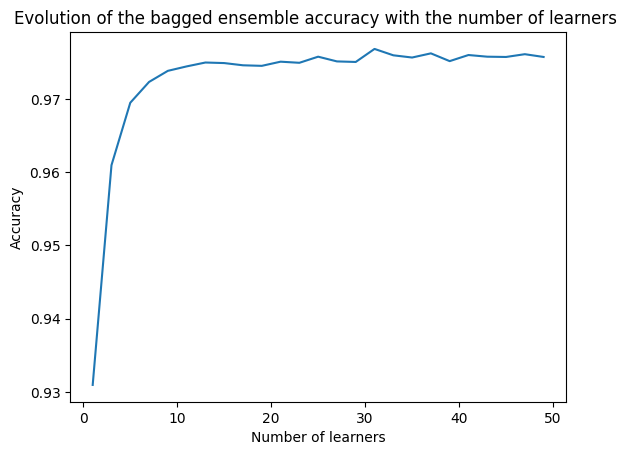

In [32]:
plt.figure()
plt.plot(rang_n_learners,acc_test_evol)
plt.xlabel('Number of learners')
plt.ylabel('Accuracy')
plt.title('Evolution of the bagged ensemble accuracy with the number of learners ')
plt.show()

### BOOSTING

In [33]:
np.random.seed(0)

from sklearn.ensemble import AdaBoostClassifier

base = tree.DecisionTreeClassifier(max_depth=1)

ADC = AdaBoostClassifier(base, algorithm='SAMME', n_estimators=200).fit(X_train, y_train)
acc_AB_R = ADC.score(X_test, y_test)

print('Accuracy of discrete adaboost ensemble is %2.2f '%(100*acc_AB_R))

Accuracy of discrete adaboost ensemble is 56.82 


In [34]:
X_train.shape

(1583, 32)

# MODELOS DE DL

## Modelo 1

2 capas Dense (con 32 y 16 neuronas cada una) y 1 capa de salida con función de activación 'Softmax', ya que funciona muy bien en clasificación

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(7, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 1s 6ms/step - loss: 1.8712 - accuracy: 0.2220 - val_loss: 1.7428 - val_accuracy: 0.3438
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 1.6636 - accuracy: 0.3981 - val_loss: 1.5001 - val_accuracy: 0.5110
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 1.4006 - accuracy: 0.5039 - val_loss: 1.2107 - val_accuracy: 0.5647
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 1.1387 - accuracy: 0.5885 - val_loss: 0.9809 - val_accuracy: 0.6562
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.9521 - accuracy: 0.6635 - val_loss: 0.8347 - val_accuracy: 0.7035
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.8286 - accuracy: 0.7188 - val_loss: 0.7342 - val_accuracy: 0.7287
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.7268 - accuracy: 0.7615 - val_loss: 0.6503 - val_accuracy: 0.7760
Epoch 8/10
40/40 [==

In [37]:
loss, accuracy_dl1 = model.evaluate(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy_dl1 * 100:.2f}%")

17/17 [==============================] - 0s 1ms/step - loss: 0.5570 - accuracy: 0.8106
Precisión del modelo en el conjunto de prueba: 81.06%


## Modelo 2

4 capas Dense, con 256, 128, 64 y 32 neuronas cada una y 1 capa de salida con función de activación 'Softmax'

In [38]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 1s 5ms/step - loss: 1.5927 - accuracy: 0.4795 - val_loss: 1.0183 - val_accuracy: 0.6972
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7276 - accuracy: 0.7520 - val_loss: 0.4349 - val_accuracy: 0.8927
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.3205 - accuracy: 0.9092 - val_loss: 0.2174 - val_accuracy: 0.9243
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.1897 - accuracy: 0.9439 - val_loss: 0.1821 - val_accuracy: 0.9401
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.9605 - val_loss: 0.1074 - val_accuracy: 0.9621
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.9684 - val_loss: 0.1121 - val_accuracy: 0.9621
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9779 - val_loss: 0.0598 - val_accuracy: 0.9874
Epoch 8/10
40/40 [==

In [40]:
loss, accuracy_dl2 = model.evaluate(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy_dl2 * 100:.2f}%")

17/17 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.9470
Precisión del modelo en el conjunto de prueba: 94.70%


## Modelo 3

Mismo modelo que el anterior pero añadiendo capas de Dropout entre las capas Dense para ver si mejoramos el modelo

In [41]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 1s 10ms/step - loss: 1.9842 - accuracy: 0.1627 - val_loss: 1.8992 - val_accuracy: 0.4479
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 1.8929 - accuracy: 0.2141 - val_loss: 1.7292 - val_accuracy: 0.4227
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 1.7677 - accuracy: 0.2575 - val_loss: 1.4401 - val_accuracy: 0.5836
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 1.5887 - accuracy: 0.3618 - val_loss: 1.2062 - val_accuracy: 0.5836
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 1.4149 - accuracy: 0.3949 - val_loss: 1.0317 - val_accuracy: 0.5994
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 1.3117 - accuracy: 0.4510 - val_loss: 0.9271 - val_accuracy: 0.6246
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 1.2335 - accuracy: 0.4542 - val_loss: 0.8760 - val_accuracy: 0.6404
Epoch 8/10
40/40 [=

In [43]:
loss, accuracy_dl3 = model.evaluate(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy_dl3 * 100:.2f}%")

17/17 [==============================] - 0s 1ms/step - loss: 0.7134 - accuracy: 0.7576
Precisión del modelo en el conjunto de prueba: 75.76%


## Modelo 4

El modelo base es el mismo, solo que subimos las epochs a 20 para ver si mejoramos el accuracy intentando no sobreentrenar el modelo

In [44]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
40/40 [==============================] - 1s 5ms/step - loss: 1.4266 - accuracy: 0.4976 - val_loss: 0.7753 - val_accuracy: 0.7792
Epoch 2/20
40/40 [==============================] - 0s 2ms/step - loss: 0.5398 - accuracy: 0.8404 - val_loss: 0.2802 - val_accuracy: 0.9401
Epoch 3/20
40/40 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.9297 - val_loss: 0.1805 - val_accuracy: 0.9464
Epoch 4/20
40/40 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9463 - val_loss: 0.1119 - val_accuracy: 0.9716
Epoch 5/20
40/40 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.9676 - val_loss: 0.1775 - val_accuracy: 0.9148
Epoch 6/20
40/40 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.9526 - val_loss: 0.0956 - val_accuracy: 0.9621
Epoch 7/20
40/40 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9747 - val_loss: 0.0718 - val_accuracy: 0.9748
Epoch 8/20
40/40 [==

In [46]:
loss, accuracy_dl4 = model.evaluate(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy_dl4 * 100:.2f}%")

17/17 [==============================] - 0s 1ms/step - loss: 0.1733 - accuracy: 0.9527
Precisión del modelo en el conjunto de prueba: 95.27%


# TABLA DE ACCURACYS

In [47]:
import statistics

modelos = ['KNN','Regresión Logística','Ridge','SGD','OVO','OVR','Bagging','RF','Boosting','DL 1','DL 2','DL 3','DL 4']
accuracys = [accuracy_KNN, accuracy_LR, accuracy_RIDGE, accuracy_SGD, acc_1vsall, acc_1vs1, mean_acc_Bagging, 
             statistics.mean(acc_test_evol), acc_AB_R, accuracy_dl1, accuracy_dl2, accuracy_dl3, accuracy_dl4]
             

df = pd.DataFrame()

df['Modelos'] = modelos
df['Accuracys'] = accuracys

In [48]:
df

,Modelos,Accuracys
0,KNN,0.880682
1,Regresión Logística,0.869318
2,Ridge,0.653409
3,SGD,0.778409
4,OVO,0.776515
5,OVR,0.960227
6,Bagging,0.973485
7,RF,0.972633
8,Boosting,0.568182
9,DL 1,0.810606


Vamos a poner los accuracys en orden para ver cuáles son los modelos que mejores resultados nos aportan

In [49]:
df.sort_values(by='Accuracys', ascending=False)

,Modelos,Accuracys
6,Bagging,0.973485
7,RF,0.972633
5,OVR,0.960227
12,DL 4,0.952652
10,DL 2,0.946970
0,KNN,0.880682
1,Regresión Logística,0.869318
9,DL 1,0.810606
3,SGD,0.778409
4,OVO,0.776515


Como podemos ver el top 3 de modelos creados serían el de Bagging, Random Forest y el Modelo 4 de DL. 

No podemos decir que funcionen mejor los modelos de ML frente a los de DL en este caso, ya que los accuracys de ambos son muy buenos, simplemente hay modelos que funcionan mejor que otros. 
Además, los accuracys por lo general son bastante buenos, teniendo al menos 5 modelos que predicen bien más del 90% de las veces.